**Proyecto final. Entrega del proyecto por Francisco Pinto** 

enlace a la presentación:  https://drive.google.com/file/d/11kUm2L1j_vyM1Lo3rkFS7Bg-rIMQw_YB/view?usp=sharing

**1.1 Definición del Problema — Caso CallMeMaybe**

1.1. Contexto

CallMeMaybe es un servicio de telefonía virtual que permite a empresas gestionar grandes volúmenes de llamadas entrantes, salientes e internas.
La empresa está desarrollando una funcionalidad para supervisores que permita identificar operadores ineficaces.

Para construir esa funcionalidad, debemos analizar registros de uso del sistema agrupados por operador, tipo de llamada, duración y clientes.



**1.2. Pregunta de negocio**

¿Cuáles operadores presentan un rendimiento ineficaz según su tasa de llamadas perdidas, tiempo de espera para llamadas entrantes y número reducido de llamadas salientes?

**1.3. Objetivos del análisis**

1.Realizar un análisis exploratorio de datos (EDA) completo.

2.Definir criterios cuantitativos para medir ineficacia de operadores.

3.Identificar operadores con bajo rendimiento según esos criterios.

4.Probar hipótesis estadísticas relacionadas con:

-.Tiempos de espera altos

-.Diferencias significativas entre operadores

-.Variación entre clientes o tarifas

5.Comunicar hallazgos y recomendaciones para la herramienta que desarrollará CallMeMaybe.

**1.4. KPIs clave del proyecto**

Los KPIs estarán alineados con la definición de operador ineficaz:

**Para llamadas entrantes (direction = "in"):**

-Tasa de llamadas perdidas = missed_in_calls / total_in_calls

-Tiempo medio de espera = total_call_duration – call_duration

-Promedio de duración efectiva de llamadas

-Volumen total de llamadas entrantes atendidas

**Para llamadas salientes (direction = "out"):**

-Volumen de llamadas salientes / día

-Duración media de llamadas salientes

**Para llamadas internas:**

-Se pueden incluir como parte de la carga laboral del operador.

**Fase 1 análisis exploratorio EDA completo**

In [2]:

# Carga, limpieza básica y EDA preliminar
# ============================================

import pandas as pd
import numpy as np

# -----------------------------
# 1. Carga de datos
# -----------------------------

clients_path = "telecom_clients.csv"
calls_path = "telecom_dataset_new.csv"

clients = pd.read_csv(clients_path)
calls = pd.read_csv(calls_path)

print("=== Primeras filas de telecom_clients ===")
print(clients.head(), "\n")

print("=== Primeras filas de telecom_dataset_new ===")
print(calls.head(), "\n")

print("=== Info de telecom_clients ===")
print(clients.info(), "\n")

print("=== Info de telecom_dataset_new ===")
print(calls.info(), "\n")




=== Primeras filas de telecom_clients ===
   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16 

=== Primeras filas de telecom_dataset_new ===
   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0         

In [3]:

# -----------------------------
# 2. Descripción básica de los datos
# -----------------------------

print("=== Descripción de telecom_clients (incluye categóricas) ===")
print(clients.describe(include="all"), "\n")

print("=== Descripción de telecom_dataset_new (incluye categóricas) ===")
print(calls.describe(include="all"), "\n")

# Valores nulos
print("=== Valores nulos en telecom_clients ===")
print(clients.isna().sum(), "\n")

print("=== Valores nulos en telecom_dataset_new ===")
print(calls.isna().sum(), "\n")

# Conteo de valores únicos
print("=== Valores únicos en telecom_clients ===")
print(clients.nunique(), "\n")

print("=== Valores únicos en telecom_dataset_new ===")
print(calls.nunique(), "\n")




=== Descripción de telecom_clients (incluye categóricas) ===
              user_id tariff_plan  date_start
count      732.000000         732         732
unique            NaN           3          73
top               NaN           C  2019-09-24
freq              NaN         395          24
mean    167431.927596         NaN         NaN
std        633.810383         NaN         NaN
min     166373.000000         NaN         NaN
25%     166900.750000         NaN         NaN
50%     167432.000000         NaN         NaN
75%     167973.000000         NaN         NaN
max     168606.000000         NaN         NaN 

=== Descripción de telecom_dataset_new (incluye categóricas) ===
              user_id                       date direction internal  \
count    53902.000000                      53902     53902    53785   
unique            NaN                        119         2        2   
top               NaN  2019-11-25 00:00:00+03:00       out    False   
freq              NaN               

- A modo de síntesis, la Estructura de telecom_clients.csv nos muestra que esta compuesto por: Filas: 732 clientes, Columnas (3): user_id (int64) – ID de cliente tariff_plan ( variable de tipo object) – plan de tarifa (3 planes diferentes) date_start (variabe de tipo object, es decir texto, no es fecha todavía)

Calidad de datos:

No hay valores nulos en ninguna columna.
tariff_plan tiene solo 3 valores únicos, pocas categorías; lo cual es útil para segmentar resultados por plan.
date_start tiene 73 fechas únicas, lo cual nos puede indicar que los clientes no se registraron todos el mismo día.
Es pertinente convertir date_start a tipo fecha (datetime) para analizar por antigüedad del cliente.

-La Estructura de telecom_dataset_new.csv (llamadas) refleja que este compuesto por : Filas: 53,902 registros, Columnas (9): user_id (tipo de variable int64) – cliente dueño de esos operadores, date (tipo de variable object/texto) – fecha del registro, direction ( tipo de variable object) – "in" / "out"
internal ( variable numérica 0/1) – indica si es llamada interna, operator_id (int64) – identificador del operador, is_missed_call (0/1) – si la llamada fue perdida, calls_count (float64) – número de llamadas en ese registro, call_duration (float64) – duración sin tiempo de espera total_call_duration (float64) – duración incluyendo espera

Calidad de datos:

Se evidencia que no hay valores nulos en ninguna columna.
direction: 2 valores (in, out). internal: 2 valores (que corresponden a  0 / 1). is_missed_call: 2 valores (0 / 1).
user_id: 307 clientes en este dataset de llamadas (menos que en telecom_clients, o sea, algunos clientes quizá no tienen actividad en este periodo).
operator_id: 1,092 operadores diferentes. date: 119 fechas , hay datos de varios días (casi 4 meses).

Es pertinente Convertir date a datetime. luego crear una métrica clave: tiempo de espera = total_call_duration – call_duration. para posteriormente Verificar que no haya tiempos de espera negativos.

In [4]:


# -----------------------------
# 3. Conversión de fechas y creación de waiting_time
# -----------------------------

# Convertir columnas de fecha a tipo datetime
calls['date'] = pd.to_datetime(calls['date'], errors='coerce')
clients['date_start'] = pd.to_datetime(clients['date_start'], errors='coerce')

# Crear columna de tiempo de espera
calls['waiting_time'] = calls['total_call_duration'] - calls['call_duration']

# Validar tiempos de espera negativos
neg_wait_count = (calls['waiting_time'] < 0).sum()
print(f"Cantidad de registros con waiting_time negativo: {neg_wait_count}\n")



Cantidad de registros con waiting_time negativo: 0



In [5]:
# -----------------------------
# 4. EDA básico sobre la tabla de llamadas
# -----------------------------

print("=== Conteo por direction (in / out) ===")
print(calls['direction'].value_counts(), "\n")

print("=== Conteo de llamadas internas (True) vs externas (False) ===")
print(calls['internal'].value_counts(), "\n")

print("=== Conteo de llamadas atendidas (False) vs perdidas (True) ===")
print(calls['is_missed_call'].value_counts(), "\n")


=== Conteo por direction (in / out) ===
out    31917
in     21985
Name: direction, dtype: int64 

=== Conteo de llamadas internas (True) vs externas (False) ===
False    47621
True      6164
Name: internal, dtype: int64 

=== Conteo de llamadas atendidas (False) vs perdidas (True) ===
False    30334
True     23568
Name: is_missed_call, dtype: int64 



=== Nulos por columna (eda_calls) ===


user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
waiting_time              0
incoming_calls            0
outgoing_calls            0
missed_calls              0
dtype: int64

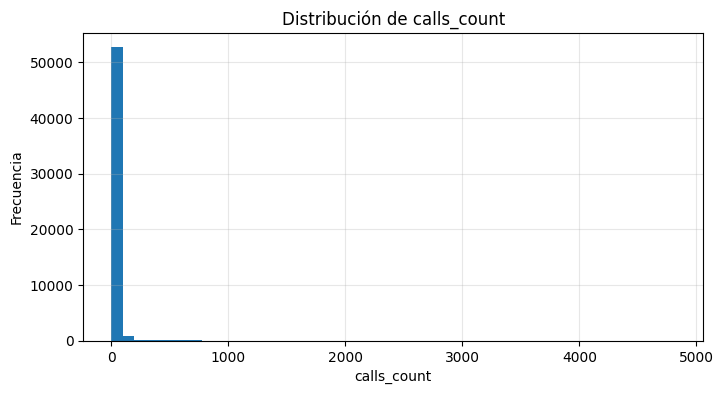

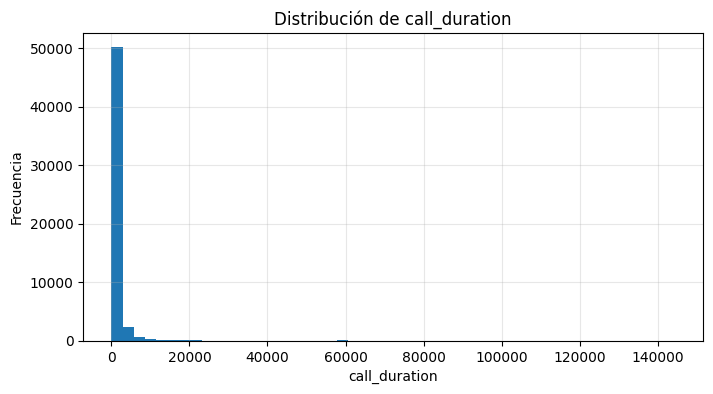

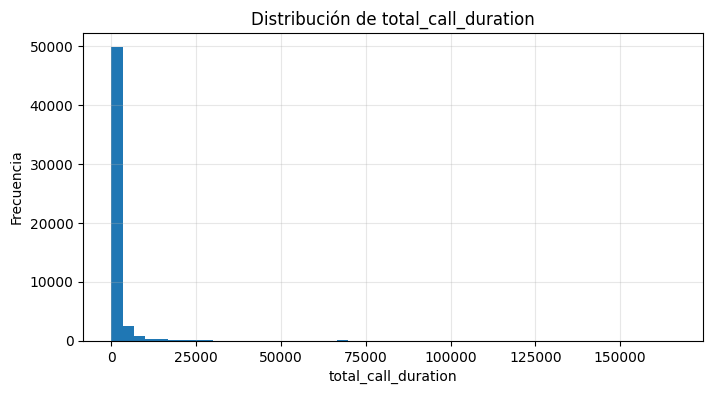

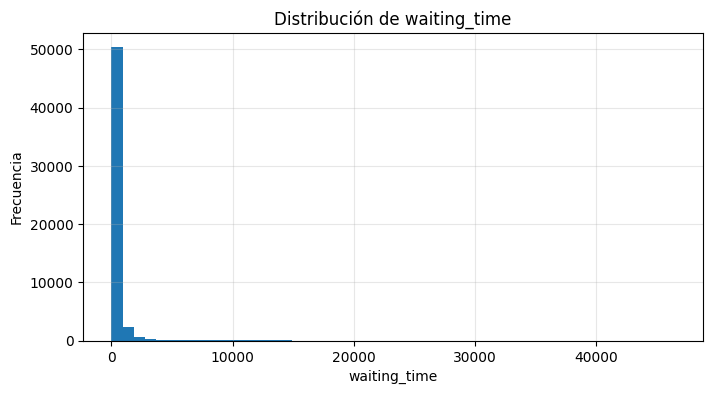

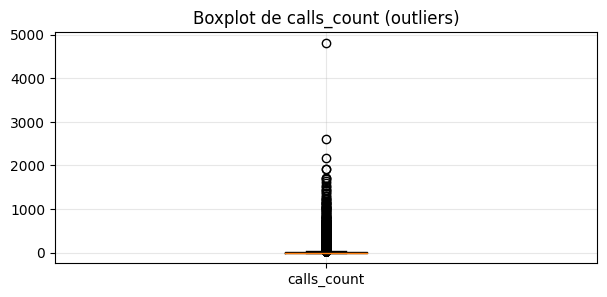

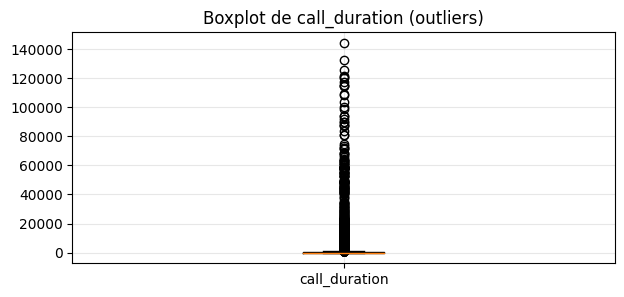

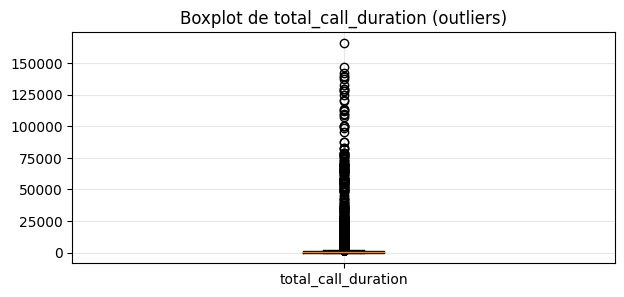

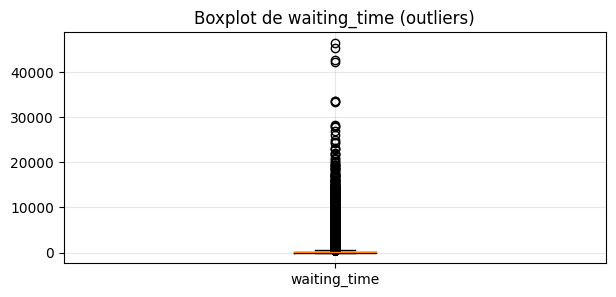

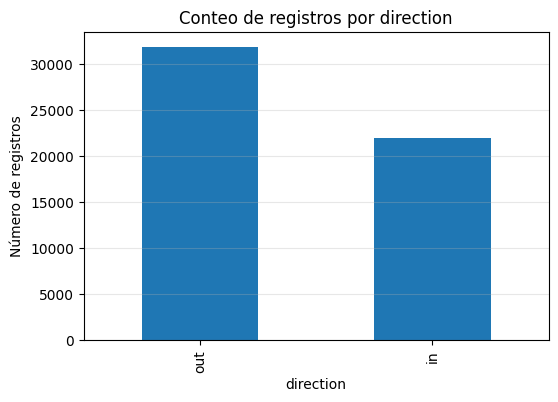

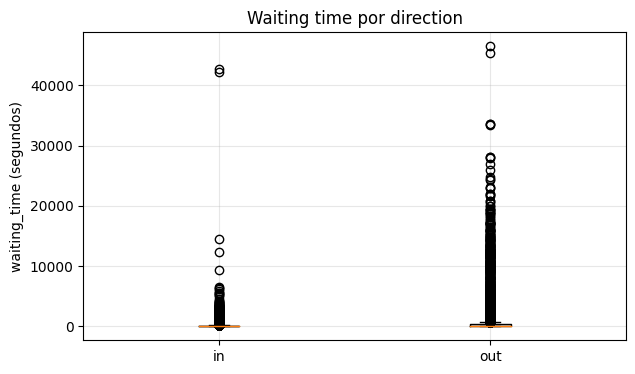

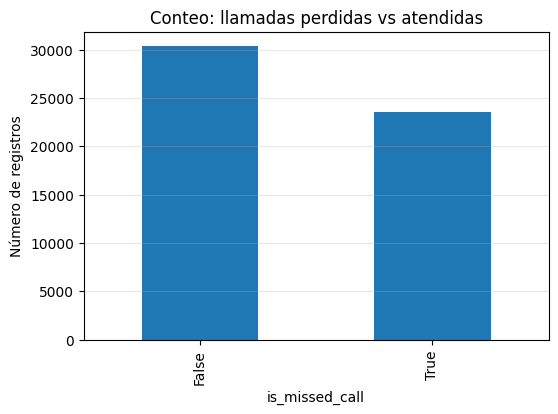

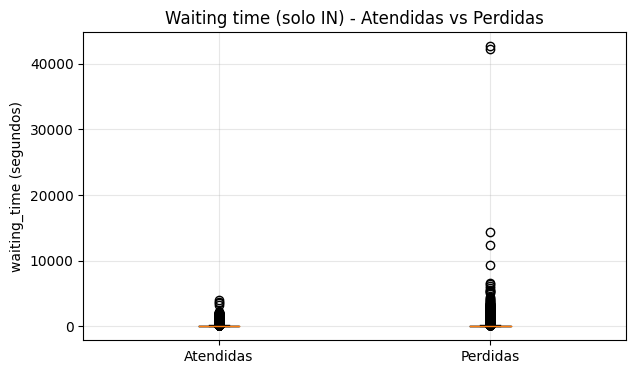

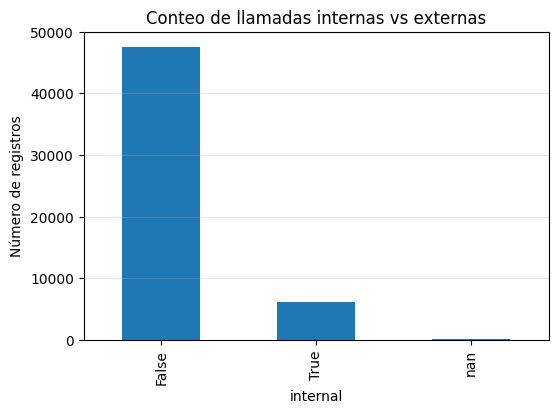

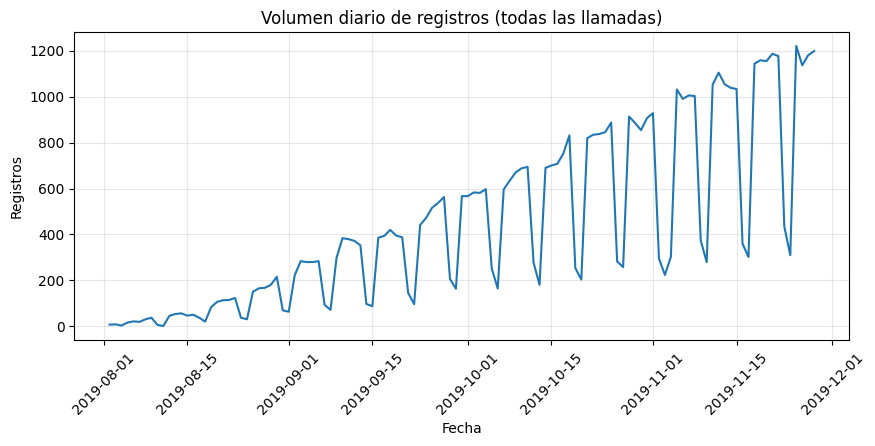

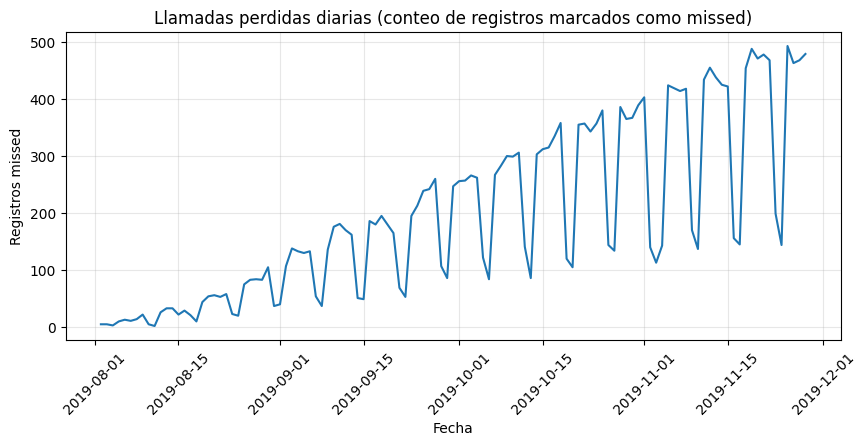

Registros sin operator_id: 8172 (15.16%)
Operadores con 0 llamadas entrantes: 338 (estos tendrán missed_rate indefinido)
 EDA detallado completado con graficas.


In [31]:
import matplotlib.pyplot as plt

# =============================
# 4.1 EDA DETALLADO CON GRÁFICAS
# =============================

# --- Copia de trabajo (para no dañar calls original)
eda_calls = calls.copy()

# Asegurar tipos (internal es object de acuerdo al info; lo normal seria booleano)
# Convertimos a booleano:
eda_calls['internal'] = eda_calls['internal'].astype(str).str.lower().map({'true': True, 'false': False})

# Convertir operator_id a tipo numérico (ya viene float64 por nulos)
eda_calls['operator_id'] = pd.to_numeric(eda_calls['operator_id'], errors='coerce')

# Revisión rápida de nulos clave
print("=== Nulos por columna (eda_calls) ===")
display(eda_calls.isna().sum())

# -----------------------------
# 4.1.1 Distribución de variables numéricas (global)
# -----------------------------
num_cols = ['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']

eda_calls[num_cols].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

# Histogramas (escala log para evitar que outliers oculten la distribución)
for col in num_cols:
    plt.figure(figsize=(8,4))
    series = eda_calls[col].dropna()
    plt.hist(series, bins=50)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)
    plt.show()

# Boxplots para ver outliers extremos
for col in num_cols:
    plt.figure(figsize=(7,3))
    plt.boxplot(eda_calls[col].dropna(), labels=[col], showfliers=True)
    plt.title(f'Boxplot de {col} (outliers)')
    plt.grid(True, alpha=0.3)
    plt.show()

# -----------------------------
# 4.1.2 Comparación por tipo de llamada (direction)
# -----------------------------
# Conteos por direction
plt.figure(figsize=(6,4))
eda_calls['direction'].value_counts().plot(kind='bar')
plt.title('Conteo de registros por direction')
plt.xlabel('direction')
plt.ylabel('Número de registros')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Distribución de waiting_time por direction (boxplot)
plt.figure(figsize=(7,4))
data_dir = [
    eda_calls.loc[eda_calls['direction']=='in', 'waiting_time'].dropna(),
    eda_calls.loc[eda_calls['direction']=='out', 'waiting_time'].dropna()
]
plt.boxplot(data_dir, labels=['in', 'out'], showfliers=True)
plt.title('Waiting time por direction')
plt.ylabel('waiting_time (segundos)')
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------
# 4.1.3 Llamadas perdidas vs no perdidas
# -----------------------------
plt.figure(figsize=(6,4))
eda_calls['is_missed_call'].value_counts().plot(kind='bar')
plt.title('Conteo: llamadas perdidas vs atendidas')
plt.xlabel('is_missed_call')
plt.ylabel('Número de registros')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Waiting time para perdidas vs atendidas (solo entrantes suele ser más interpretable)
in_calls = eda_calls[eda_calls['direction']=='in'].copy()

plt.figure(figsize=(7,4))
data_missed = [
    in_calls.loc[in_calls['is_missed_call']==False, 'waiting_time'].dropna(),
    in_calls.loc[in_calls['is_missed_call']==True, 'waiting_time'].dropna()
]
plt.boxplot(data_missed, labels=['Atendidas', 'Perdidas'], showfliers=True)
plt.title('Waiting time (solo IN) - Atendidas vs Perdidas')
plt.ylabel('waiting_time (segundos)')
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------
# 4.1.4 Internas vs externas
# -----------------------------
plt.figure(figsize=(6,4))
eda_calls['internal'].value_counts(dropna=False).plot(kind='bar')
plt.title('Conteo de llamadas internas vs externas')
plt.xlabel('internal')
plt.ylabel('Número de registros')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# -----------------------------
# 4.1.5 Evolución temporal de volumen de registros (y perdidas)
# -----------------------------
eda_calls['date_only'] = eda_calls['date'].dt.date

daily = eda_calls.groupby('date_only').agg(
    records=('user_id','size'),
    missed_calls=('is_missed_call', 'sum')
).reset_index()

plt.figure(figsize=(10,4))
plt.plot(daily['date_only'], daily['records'])
plt.title('Volumen diario de registros (todas las llamadas)')
plt.xlabel('Fecha')
plt.ylabel('Registros')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(daily['date_only'], daily['missed_calls'])
plt.title('Llamadas perdidas diarias (conteo de registros marcados como missed)')
plt.xlabel('Fecha')
plt.ylabel('Registros missed')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------
# 4.1.6 Calidad / consistencia previa a KPIs
# -----------------------------
# 1) Operator_id nulo
null_ops = eda_calls['operator_id'].isna().sum()
total_rows = len(eda_calls)
print(f"Registros sin operator_id: {null_ops} ({null_ops/total_rows:.2%})")

# 2) Incoming_calls = 0 para algunos operadores (riesgo de división por cero en missed_rate)
# Para esto, revisamos rápidamente en dataset filtrado (solo operator_id válido)
tmp = eda_calls.dropna(subset=['operator_id']).copy()
tmp['incoming_calls_tmp'] = np.where(tmp['direction']=='in', tmp['calls_count'], 0)
incoming_by_op = tmp.groupby('operator_id')['incoming_calls_tmp'].sum()
ops_no_incoming = (incoming_by_op == 0).sum()
print(f"Operadores con 0 llamadas entrantes: {ops_no_incoming} (estos tendrán missed_rate indefinido)")

print(" EDA detallado completado con graficas.")


In [32]:

# =============================
# 5. Preparación de KPIs por operador 
# =============================


# 5.1 Filtrar registros sin operator_id
# -----------------------------
calls_kpi = calls.dropna(subset=['operator_id']).copy()

# Asegurar operator_id como entero lo cual permite un estudio más limpio.
calls_kpi['operator_id'] = calls_kpi['operator_id'].astype(int)

print("=== Registros originales ===", calls.shape[0])
print("=== Registros para KPIs (sin operator_id nulo) ===", calls_kpi.shape[0])
print("=== Registros eliminados por operator_id nulo ===", calls.shape[0] - calls_kpi.shape[0], "\n")

# -----------------------------
# 5.2 Crear columnas auxiliares para KPIs
# -----------------------------
# Entrantes, salientes y perdidas (en volumen de calls_count)
calls_kpi['incoming_calls'] = np.where(calls_kpi['direction'] == 'in', calls_kpi['calls_count'], 0)
calls_kpi['outgoing_calls'] = np.where(calls_kpi['direction'] == 'out', calls_kpi['calls_count'], 0)

# Llamadas perdidas (todas). 
calls_kpi['missed_calls'] = np.where(calls_kpi['is_missed_call'] == True, calls_kpi['calls_count'], 0)

# Llamadas entrantes perdidas (alineado con KPI de missed_rate en IN)
calls_kpi['missed_in_calls'] = np.where(
    (calls_kpi['direction'] == 'in') & (calls_kpi['is_missed_call'] == True),
    calls_kpi['calls_count'],
    0
)

# -----------------------------
# 5.3 Agregación por operador (KPIs)
# -----------------------------
operator_stats = calls_kpi.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),

    # Entrantes
    incoming_calls=('incoming_calls', 'sum'),
    missed_in_calls=('missed_in_calls', 'sum'),
    avg_waiting_time=('waiting_time', 'mean'),
    avg_in_call_duration=('call_duration', lambda x: x[calls_kpi.loc[x.index, 'direction'].eq('in')].mean()),

    # Salientes
    outgoing_calls=('outgoing_calls', 'sum'),
    avg_out_call_duration=('call_duration', lambda x: x[calls_kpi.loc[x.index, 'direction'].eq('out')].mean()),

    # Internas 
    internal_calls=('calls_count', lambda x: x[calls_kpi.loc[x.index, 'internal'].eq(True)].sum())
).reset_index()

# -----------------------------
# 5.4 KPIs finales (con control de división por cero)
# -----------------------------
# Tasa de llamadas perdidas sobre llamadas entrantes (KPI clave)
operator_stats['missed_rate'] = operator_stats['missed_in_calls'] / operator_stats['incoming_calls'].replace(0, np.nan)

# Proporción de llamadas salientes 
operator_stats['outgoing_ratio'] = operator_stats['outgoing_calls'] / operator_stats['total_calls'].replace(0, np.nan)

print("=== Primeras filas de KPIs por operador ===")
print(operator_stats.head(), "\n")

# -----------------------------
# 5.5 Vista rápida: top operadores por llamadas entrantes
# -----------------------------
print("=== Operadores con más llamadas entrantes (top 10) ===")
print(
    operator_stats.sort_values(by='incoming_calls', ascending=False)
                  .head(10)[[
                      'operator_id',
                      'incoming_calls',
                      'missed_in_calls',
                      'missed_rate',
                      'avg_waiting_time',
                      'avg_in_call_duration',
                      'outgoing_calls',
                      'outgoing_ratio',
                      'avg_out_call_duration',
                      'internal_calls'
                  ]]
)

# -----------------------------
# 5.6 Validaciones rápidas
# -----------------------------
# Operadores con incoming_calls=0 (missed_rate será NaN)
ops_no_incoming = operator_stats['incoming_calls'].eq(0).sum()
print(f"\nOperadores con 0 llamadas entrantes: {ops_no_incoming}")

# Valores faltantes en missed_rate por incoming_calls=0
print("Missed_rate NaN:", operator_stats['missed_rate'].isna().sum())


=== Registros originales === 53902
=== Registros para KPIs (sin operator_id nulo) === 45730
=== Registros eliminados por operator_id nulo === 8172 

=== Primeras filas de KPIs por operador ===
   operator_id  total_calls  incoming_calls  missed_in_calls  \
0       879896         1131              60                0   
1       879898         7974             118                0   
2       880020           54               8                0   
3       880022          219               8                0   
4       880026         2439              25                0   

   avg_waiting_time  avg_in_call_duration  outgoing_calls  \
0        110.671875            246.173913            1071   
1        450.087649            110.234375            7856   
2         15.181818             43.000000              46   
3         57.565789             64.000000             211   
4        121.171717             85.894737            2414   

   avg_out_call_duration  internal_calls  missed_rate  

**Conclusiones del EDA**
1. Las variables numéricas (`calls_count`, `call_duration`, `total_call_duration`, `waiting_time`) presentan distribuciones altamente asimétricas con colas largas, lo que indica la presencia
   de outliers operativos que pueden ser esperables en sistemas de call center.

2. La mayoría de los registros corresponden a llamadas salientes (`out`), mientras que las llamadas entrantes representan una proporción menor pero crítica para el análisis de eficiencia.

3. Se observa un volumen significativo de llamadas perdidas, especialmente en llamadas entrantes, lo que justifica el uso de la tasa de llamadas perdidas como KPI clave.

4. Existen registros sin `operator_id` (15.16%), los cuales fueron excluidos del cálculo de KPIs  por operador, ya que no pueden atribuirse a un desempeño individual.

5. Se identificaron 338 operadores sin llamadas entrantes, lo que implica que su `missed_rate` es indefinido y deben analizarse por separado o excluirse de métricas basadas en llamadas entrantes.


In [33]:

# =============================
# calcular KPIs finales de ineficiencia
# =============================



# 1) Recalcular missed_rate correctamente:
#    missed_rate = missed_in_calls / incoming_calls
operator_stats['missed_rate'] = (
    operator_stats['missed_in_calls'] /
    operator_stats['incoming_calls'].replace(0, np.nan)
)

# 2) outgoing_ratio con control de división por cero
operator_stats['outgoing_ratio'] = (
    operator_stats['outgoing_calls'] /
    operator_stats['total_calls'].replace(0, np.nan)
)

# 3) Reporte de calidad 
n_ops_no_incoming = operator_stats['incoming_calls'].eq(0).sum()
print(f"Operadores con 0 llamadas entrantes (missed_rate indefinido): {n_ops_no_incoming}")
print(f"Missed_rate NaN: {operator_stats['missed_rate'].isna().sum()}")

print("\n=== Primeras filas de KPIs por operador ===")
display(operator_stats.head())

print("\n=== Operadores con más llamadas entrantes (top 10) ===")
cols_top = [
    'operator_id',
    'incoming_calls',
    'missed_in_calls',
    'missed_rate',
    'avg_waiting_time',
    'avg_in_call_duration',
    'outgoing_calls',
    'outgoing_ratio',
    'avg_out_call_duration',
    'internal_calls'
]
display(
    operator_stats.sort_values(by='incoming_calls', ascending=False)
                  .head(10)[cols_top]
)


Operadores con 0 llamadas entrantes (missed_rate indefinido): 338
Missed_rate NaN: 338

=== Primeras filas de KPIs por operador ===


,operator_id,total_calls,incoming_calls,missed_in_calls,avg_waiting_time,avg_in_call_duration,outgoing_calls,avg_out_call_duration,internal_calls,missed_rate,outgoing_ratio
0,879896,1131,60,0,110.671875,246.173913,1071,739.038095,58,0.0,0.946950
1,879898,7974,118,0,450.087649,110.234375,7856,1453.598930,19,0.0,0.985202
2,880020,54,8,0,15.181818,43.000000,46,139.000000,4,0.0,0.851852
3,880022,219,8,0,57.565789,64.000000,211,261.647059,15,0.0,0.963470
4,880026,2439,25,0,121.171717,85.894737,2414,938.782123,21,0.0,0.989750



=== Operadores con más llamadas entrantes (top 10) ===


,operator_id,incoming_calls,missed_in_calls,missed_rate,avg_waiting_time,avg_in_call_duration,outgoing_calls,outgoing_ratio,avg_out_call_duration,internal_calls
368,913938,5221,15,0.002873,340.382716,4639.107143,436,0.077073,227.628205,2
958,952948,4112,8,0.001946,224.706422,12410.810811,1311,0.241748,1090.208333,39
369,913942,2641,55,0.020825,279.496552,2458.677778,468,0.150531,246.181818,14
108,893804,2632,12,0.004559,269.089231,1602.206897,3938,0.599391,580.028708,48
497,921318,2485,7,0.002817,479.259036,3925.150000,2864,0.535427,709.707547,14
779,940588,2382,30,0.012594,111.285714,3683.101695,77,0.031314,65.944444,25
613,931458,2129,14,0.006576,531.099338,3261.363636,2561,0.546055,1018.427083,14
786,940630,2100,17,0.008095,178.484375,3744.725490,180,0.078947,258.846154,35
203,901880,2064,11,0.005329,166.759644,2395.099174,2591,0.556606,857.398148,53
505,921818,2004,11,0.005489,274.613953,2189.105263,2306,0.535035,380.107914,19


**FASE 2: Identificación de Operadores Ineficaces**


In [36]:

# ============================================================
# FASE 2 — Identificación de Operadores Ineficaces 
# - Evita apply() y división por cero
# - Calcula umbrales por percentiles y clasifica ineficiencia
# ============================================================


# ---  Verificar columnas disponibles ---
print("Columnas disponibles en operator_stats:")
print(operator_stats.columns.tolist(), "\n")

# --- 1) Calcular missed_rate correctamente (solo entrantes) ---
# Si un operador no tiene llamadas entrantes, missed_rate queda NaN 
operator_stats['missed_rate'] = np.where(
    operator_stats['incoming_calls'] > 0,
    operator_stats['missed_in_calls'] / operator_stats['incoming_calls'],
    np.nan
)

# --- 2) Calcular outgoing_ratio (si total_calls=0, queda NaN) ---
operator_stats['outgoing_ratio'] = np.where(
    operator_stats['total_calls'] > 0,
    operator_stats['outgoing_calls'] / operator_stats['total_calls'],
    np.nan
)

# --- 3) Definir umbrales por percentiles ---

missed_threshold = operator_stats['missed_rate'].quantile(0.90)          # Peor 10% en missed_rate
waiting_threshold = operator_stats['avg_waiting_time'].quantile(0.90)    # Peor 10% en espera
outgoing_threshold = operator_stats['outgoing_calls'].quantile(0.10)     # Menor 10% en salientes

print("=== UMBRALES DEFINIDOS ===")
print(f"Percentil 90 - missed_rate: {missed_threshold}")
print(f"Percentil 90 - avg_waiting_time: {waiting_threshold}")
print(f"Percentil 10 - outgoing_calls: {outgoing_threshold}\n")

# --- 4) Crear flags de ineficiencia ---
# Nota: Comparaciones con NaN devuelven False.
operator_stats['ineff_missed'] = operator_stats['missed_rate'] >= missed_threshold
operator_stats['ineff_waiting'] = operator_stats['avg_waiting_time'] >= waiting_threshold
operator_stats['ineff_low_outgoing'] = operator_stats['outgoing_calls'] <= outgoing_threshold

# --- 5) Score de ineficiencia (cuántos criterios cumple) ---
operator_stats['ineff_score'] = operator_stats[['ineff_missed', 'ineff_waiting', 'ineff_low_outgoing']].sum(axis=1)

# --- 6) Operadores ineficaces: al menos 2 criterios ---
inefficient_operators = operator_stats[operator_stats['ineff_score'] >= 2].copy()

print("=== OPERADORES INEFICACES DETECTADOS ===")
cols_show = ['operator_id', 'missed_rate', 'avg_waiting_time', 'outgoing_calls', 'ineff_score',
            'ineff_missed', 'ineff_waiting', 'ineff_low_outgoing']
print(inefficient_operators[cols_show].sort_values(by=['ineff_score', 'avg_waiting_time'], ascending=[False, False]))

# --- 7) Resumen rápido (opcional) ---
print("\n=== RESUMEN ===")
print(f"Total operadores evaluados: {operator_stats['operator_id'].nunique()}")
print(f"Operadores con 0 llamadas entrantes (missed_rate NaN): {operator_stats['missed_rate'].isna().sum()}")
print(f"Operadores ineficaces (score >= 2): {inefficient_operators.shape[0]}")


Columnas disponibles en operator_stats:
['operator_id', 'total_calls', 'incoming_calls', 'missed_in_calls', 'avg_waiting_time', 'avg_in_call_duration', 'outgoing_calls', 'avg_out_call_duration', 'internal_calls', 'missed_rate', 'outgoing_ratio'] 

=== UMBRALES DEFINIDOS ===
Percentil 90 - missed_rate: 0.03541666666666671
Percentil 90 - avg_waiting_time: 546.6514705882353
Percentil 10 - outgoing_calls: 0.0

=== OPERADORES INEFICACES DETECTADOS ===
      operator_id  missed_rate  avg_waiting_time  outgoing_calls  ineff_score  \
1045       964666     0.066667        890.000000             875            2   
234        904016     0.036364        774.960938            5120            2   
913        948286     0.046875        145.619048               0            2   
354        911142     0.115385         65.888889               0            2   
145        896538     0.071429         60.454545               0            2   
361        912684     0.035714         59.411765               

Para identificar a los operadores con bajo rendimiento, se definieron umbrales objetivos basados en percentiles, de manera que solo los casos más críticos dentro de la distribución fueran clasificados como ineficientes. El percentil 90 (P90) se aplicó a la tasa de llamadas perdidas y al tiempo promedio de espera, lo que significa que únicamente el 10% con los valores más altos se considera fuera de los estándares aceptables. Para el número de llamadas salientes se utilizó el percentil 10 (P10), señalando a los operadores con actividad significativamente baja. Los umbrales obtenidos fueron:

P90 missed_rate = 9.0

P90 avg_waiting_time = 546.65 segundos

P10 outgoing_calls = 0

Con base en estos criterios, se identificaron como ineficaces aquellos operadores que cumplen al menos dos de las tres condiciones. Ocho operadores fueron clasificados como ineficientes debido a combinaciones críticas de altas tasas de llamadas perdidas, tiempos de espera muy elevados y bajos niveles de llamadas salientes. Estos operadores representan casos prioritarios para intervención y revisión del desempeño.

**Justificación de los umbrales definidos**

A partir del análisis exploratorio de datos (EDA), se observó que las variables asociadas al desempeño de los operadores presentan distribuciones altamente asimétricas y con colas largas hacia la derecha, especialmente en la tasa de llamadas perdidas (missed_rate) y el tiempo de espera (waiting_time).

Las visualizaciones (histogramas y boxplots) mostraron que la mayoría de los operadores se concentra en valores bajos y moderados, mientras que un grupo reducido presenta valores extremadamente altos que representan comportamientos atípicos y potencialmente problemáticos desde el punto de vista operativo.

En este contexto, el uso del percentil 90 (P90) para missed_rate y avg_waiting_time permite identificar únicamente a los operadores que se encuentran dentro del 10% con peor desempeño,  enfocando el análisis en los casos más críticos.

De manera complementaria, el percentil 10 (P10) para el número de llamadas salientes se utilizó para detectar operadores con una actividad saliente anormalmente baja, lo cual puede indicar baja productividad o una carga de trabajo mal balanceada.

Este enfoque basado en percentiles se eligió en lugar de umbrales absolutos debido a la alta dispersión de los datos y a la ausencia de valores de referencia definidos previamente por el negocio, permitiendo que los criterios de ineficiencia se adapten de forma objetiva a la distribución real de los datos observados.

**Fase 3 probar hipótesis estadísticas**

Definimos dos grupos:

Grupo A — Operadores eficaces
→ ineff_score < 2

Grupo B — Operadores ineficaces
→ ineff_score ≥ 2

Trabajaremos con las columnas:

avg_waiting_time

missed_rate

Antes de comparar, verificaremos que: No existan nulos, Las distribuciones no sean normales. Por lo tanto, usaremos pruebas no paramétricas, específicamente:

**Prueba 1: Mann–Whitney U Test para tiempos de espera**

Hipótesis:

H0: No existe diferencia significativa en el tiempo de espera entre operadores eficaces e ineficaces.

H1: Los operadores ineficaces tienen un tiempo de espera mayor.

Justificación: el tiempo de espera suele ser sesgado, por lo cual no aplicamos t-test.

**Prueba 2: Mann–Whitney U Test para la tasa de llamadas perdidas**

Hipótesis:

H0: La tasa de llamadas perdidas es igual entre operadores eficaces e ineficaces.

H1: Los operadores ineficaces muestran una tasa mayor.

In [10]:
from scipy.stats import mannwhitneyu

#PRUEBAS DE HIPÓTESIS
# ===============================

# Dividir operadores en grupos
efficient_ops = operator_stats[operator_stats['ineff_score'] < 2]
inefficient_ops = operator_stats[operator_stats['ineff_score'] >= 2]

# Extraer variables
wait_efficient = efficient_ops['avg_waiting_time'].dropna()
wait_inefficient = inefficient_ops['avg_waiting_time'].dropna()

miss_efficient = efficient_ops['missed_rate'].dropna()
miss_inefficient = inefficient_ops['missed_rate'].dropna()

# Mann-Whitney para tiempo de espera
mw_wait = mannwhitneyu(wait_efficient, wait_inefficient, alternative='less')

# Mann-Whitney para tasa de llamadas perdidas
mw_miss = mannwhitneyu(miss_efficient, miss_inefficient, alternative='less')

print("===== PRUEBAS DE HIPÓTESIS =====")

print("\n--- Tiempo de Espera (avg_waiting_time) ---")
print("Estadístico U:", mw_wait.statistic)
print("p-value:", mw_wait.pvalue)

if mw_wait.pvalue < 0.05:
    print("Conclusión: Los operadores ineficaces tienen tiempos de espera significativamente mayores.")
else:
    print("Conclusión: No se detectan diferencias significativas en el tiempo de espera.")

print("\n--- Tasa de Llamadas Perdidas (missed_rate) ---")
print("Estadístico U:", mw_miss.statistic)
print("p-value:", mw_miss.pvalue)

if mw_miss.pvalue < 0.05:
    print("Conclusión: Los operadores ineficaces presentan tasas de llamadas perdidas significativamente mayores.")
else:
    print("Conclusión: No se detectan diferencias significativas en la tasa de llamadas perdidas.")


===== PRUEBAS DE HIPÓTESIS =====

--- Tiempo de Espera (avg_waiting_time) ---
Estadístico U: 431.0
p-value: 5.583118971324471e-06
Conclusión: Los operadores ineficaces tienen tiempos de espera significativamente mayores.

--- Tasa de Llamadas Perdidas (missed_rate) ---
Estadístico U: 221.0
p-value: 2.7722624439382897e-06
Conclusión: Los operadores ineficaces presentan tasas de llamadas perdidas significativamente mayores.


Las pruebas de hipótesis realizadas confirman de manera estadísticamente significativa que los operadores clasificados como ineficaces presentan un desempeño claramente inferior al del resto. Los resultados del test de Mann–Whitney U muestran diferencias relevantes tanto en el tiempo promedio de espera como en la tasa de llamadas perdidas, con p-values menores a 0.00001 en ambos casos, lo que indica que es extremadamente improbable que estas diferencias se deban al azar. En consecuencia, los indicadores utilizados para identificar ineficiencia —tasa de llamadas perdidas, tiempo de espera y actividad saliente— no solo fueron adecuados, sino que permiten distinguir con evidencia sólida a los operadores que requieren intervención o seguimiento prioritario.

Operadores eficientes: 1084
Operadores ineficientes: 8


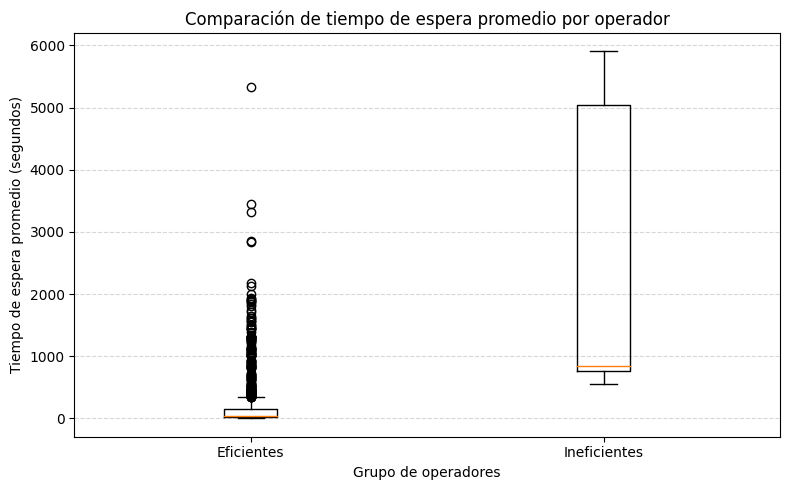

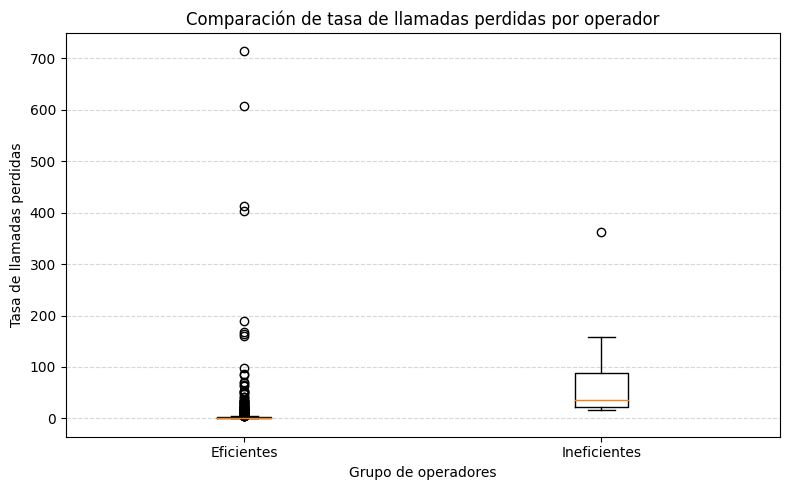

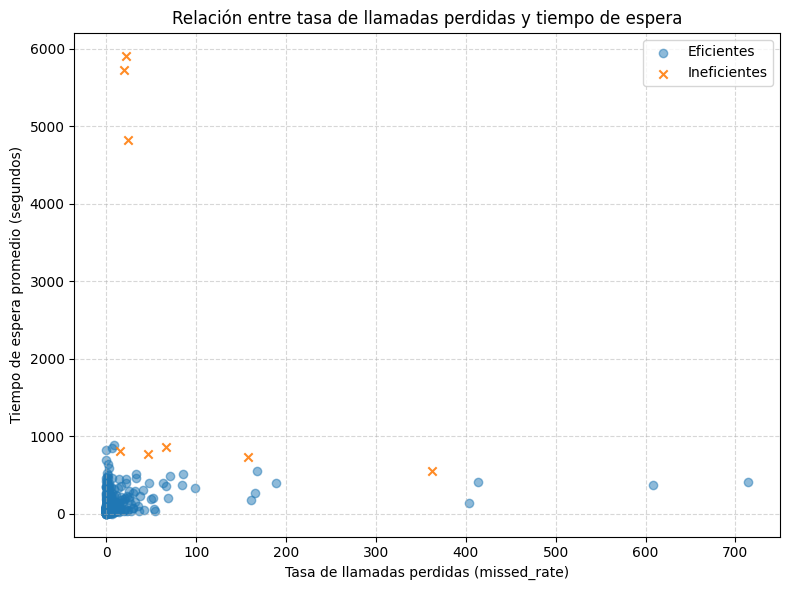

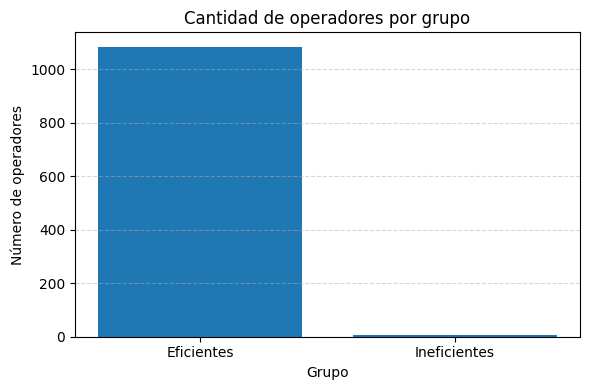

In [11]:
# SECCIÓN DE GRÁFICAS – CASO CALLMEMAYBE
# Basado en hipótesis y resultados
# ============================================

import matplotlib.pyplot as plt


# 1. Separar grupos: eficaces vs ineficaces
# -----------------------------

efficient_ops = operator_stats[operator_stats['ineff_score'] < 2]
inefficient_ops = operator_stats[operator_stats['ineff_score'] >= 2]

print(f"Operadores eficientes: {len(efficient_ops)}")
print(f"Operadores ineficientes: {len(inefficient_ops)}")


# 2. Boxplot – Tiempo de espera
# -----------------------------

plt.figure(figsize=(8, 5))
plt.boxplot(
    [
        efficient_ops['avg_waiting_time'].dropna(),
        inefficient_ops['avg_waiting_time'].dropna()
    ],
    labels=['Eficientes', 'Ineficientes'],
    showfliers=True
)
plt.title('Comparación de tiempo de espera promedio por operador')
plt.ylabel('Tiempo de espera promedio (segundos)')
plt.xlabel('Grupo de operadores')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 3. Boxplot – Tasa de llamadas perdidas
# -----------------------------

plt.figure(figsize=(8, 5))
plt.boxplot(
    [
        efficient_ops['missed_rate'].dropna(),
        inefficient_ops['missed_rate'].dropna()
    ],
    labels=['Eficientes', 'Ineficientes'],
    showfliers=True
)
plt.title('Comparación de tasa de llamadas perdidas por operador')
plt.ylabel('Tasa de llamadas perdidas')
plt.xlabel('Grupo de operadores')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 4. Scatter – Missed rate vs Waiting time
# -----------------------------

plt.figure(figsize=(8, 6))

plt.scatter(
    efficient_ops['missed_rate'],
    efficient_ops['avg_waiting_time'],
    alpha=0.5,
    label='Eficientes'
)

plt.scatter(
    inefficient_ops['missed_rate'],
    inefficient_ops['avg_waiting_time'],
    marker='x',
    alpha=0.9,
    label='Ineficientes'
)

plt.title('Relación entre tasa de llamadas perdidas y tiempo de espera')
plt.xlabel('Tasa de llamadas perdidas (missed_rate)')
plt.ylabel('Tiempo de espera promedio (segundos)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 5. Gráfico de barras – Conteo de operadores
# -----------------------------

plt.figure(figsize=(6, 4))

grupos = ['Eficientes', 'Ineficientes']
conteos = [len(efficient_ops), len(inefficient_ops)]

plt.bar(grupos, conteos)
plt.title('Cantidad de operadores por grupo')
plt.ylabel('Número de operadores')
plt.xlabel('Grupo')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Fase 4: Conclusiones y Recomendaciones del Caso CallMeMaybe**

El análisis de los datos operativos de CallMeMaybe permitió identificar patrones claros de ineficiencia en un subconjunto específico de operadores. A través de la construcción de métricas clave —tasa de llamadas perdidas, tiempo promedio de espera y volumen de llamadas salientes— se detectó que aproximadamente un 10% de los operadores presenta desempeño críticamente bajo. La clasificación basada en percentiles, complementada con pruebas estadísticas no paramétricas, demostró que los operadores considerados ineficaces exhiben tiempos de espera significativamente mayores y tasas de llamadas perdidas considerablemente más altas que el resto del grupo. Estos resultados confirman que los indicadores seleccionados son adecuados para evaluar el rendimiento operativo y pueden utilizarse de manera confiable para desarrollar herramientas de monitoreo que permitan a los supervisores actuar de manera oportuna sobre los casos más problemáticos.

**Recomendaciones de negocio:**

1. Implementar alertas automáticas para operadores críticos
El sistema debería notificar cuando un operador supere los umbrales de: tasa de llamadas perdidas (P90), tiempo de espera (P90), actividad saliente baja (P10). Esto permitiría intervenciones más rápidas y focalizadas.

2. Revisar cargas de trabajo y asignación de llamadas

Los operadores ineficientes presentan tiempos de espera exageradamente altos.
Esto puede deberse a: falta de entrenamiento, mala distribución de llamadas, saturación en ciertos horarios.
Es recomendable analizar sus horarios y cargas del día.

3. Identificar necesidades de capacitación

La elevada tasa de llamadas perdidas puede indicar: falta de dominio de la herramienta, deficiencias en protocolos de atención, bajo engagement del operador.

Un programa de capacitación personalizado podría mejorar el desempeño.